# Document Similarity

The goal of this notebooks is to find similar text spans across documents. For this we want to split the document into reasonable parts and compare each part to each other part (we call them "document spans"). The expected outcome is unique pairs of spans that are similar.


## Download data

First we need to download our sample documents. The samples are legal documents from EUR-Lex (https://eur-lex.europa.eu/).

## Import headers

In [1]:
import requests
import zipfile
import glob
import itertools

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer
sbert = SentenceTransformer('all-mpnet-base-v2')

import spacy
nlp = spacy.load('en_core_web_lg')

## Idea


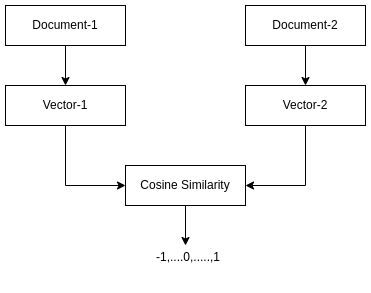


To measure the similarity between the two documents, extract vectors of those and measure cosine similarity between them.


## Approach

1. Extract the documents.
2. Take two documents at an instance to measure similairty between them.
3. Break the documents with the delimiter of new line "\n".
4. Among the broken documents convert vectors for those exceeds minimum length (in our case its 80)
5. Having two vectors find the similiarity between them using cosine.
6. If the similarity exceeds the similarity threshold (in our case its 0.5) save the value along with the pairs ensuring there is no repeatation.
7. Finally take the average of all similarity values to find the total similarity between the documents.
8. Repeat these steps for all possible pair combinations of documents (no repetation).

## Download sample documents

In [2]:
url = "https://drive.google.com/uc?export=download&id=1yEq9bgWd1wcSPG_vxRmkeOjPFgCfI5PN"
r = requests.get(url, allow_redirects=True)
open("esg_documents.zip", "wb").write(r.content)

72267

In [3]:
with zipfile.ZipFile("esg_documents.zip", "r") as f:
    f.extractall(".")

## Load the document content

In [4]:
documents = {}
for filepath in glob.glob("esg_documents/*.txt"):
    print(filepath)
    with open(filepath, "r", encoding="utf-8") as f:
        text = f.read()
        
    documents[filepath] = text

# Storing the file name as a list
file_list = [file for file in documents.keys()]

esg_documents/EU EcoLabel Regulation.txt
esg_documents/Non-Financial Reporting Directive (NFRD).txt
esg_documents/Sustainability Disclosure Regulation.txt
esg_documents/The Climate Benchmarks Regulation.txt
esg_documents/Taxonomy Regulation.txt


## Global variables

In [5]:
MINIMUM_LENGTH = 80
sim_threshold = 0.5
# Stores unique pairs with similarity value
result = {}
# Stores the pairs consider for similarity
pair_list = []
# Matrix indicating similarity between the documents
sim_matrix = np.zeros((len(file_list), len(file_list)))
# Diagonal is one as the documents are same
np.fill_diagonal(sim_matrix, 1)
# Vectorization method
vector_method = "tf_idf"

In [6]:
# Function that holds different vectorization methods
def vectorization(list_text, method = "tf_idf"):
    
    if method == "tf_idf":
      
        vectorizer = TfidfVectorizer(stop_words='english')
        vectorizer.fit_transform(list_text)
        vector1 = vectorizer.transform([list_text[0]])
        vector2 = vectorizer.transform([list_text[1]])
        arr1 = vector1.toarray()
        arr2 = vector2.toarray()

        # Compute similarity
        span_sim = cosine_similarity(arr1, arr2)[0][0]
        
        return span_sim
    
    if method == "bow":
        vectorizer = CountVectorizer(binary=True)
        matrix = vectorizer.fit_transform(list_text)               

        # Compute similarity
        span_sim = cosine_similarity([matrix.toarray()[0]], 
                                     [matrix.toarray()[1]])[0][0]
        
        return span_sim
    
    if method == "spacy":
        doc1 = nlp(para1)
        doc2 = nlp(para2)              

        # Compute similarity
        span_sim = doc1.similarity(doc2)
        
        return span_sim
    
    if method == "sentence_embedding":
        arr1 = sbert.encode(list_text[0])
        arr2 = sbert.encode(list_text[1])            

        # Compute similarity
        span_sim = cosine_similarity([arr1], [arr2])[0][0]
        
        return span_sim

## Compare document spans

In [7]:
for filepath1, filepath2 in itertools.combinations(documents, 2):
    text1 = documents[filepath1]
    text2 = documents[filepath2]
    
    
    print("\n Measuring the similarities between the documents", filepath1, "and", filepath2)
    
    # Varibale to store all the similairty values
    # of the span during two document measurement
    overall_sim = []

    for para1 in text1.split("\n\n"):

        for para2 in text2.split("\n\n"):

            if len(para1) > MINIMUM_LENGTH and len(para2) > MINIMUM_LENGTH:

                # Vectorise the span
                list_text = [para1.lower(), para2.lower()]
                span_sim = vectorization(list_text, vector_method)
                overall_sim.append(span_sim)
                
                # Threshold the similarity to store
                if span_sim >= sim_threshold:                    
                    # Supress the repeatation
                    if result.get(str(list_text)) is None and result.get(str(list_text[::-1])) is None:
                        result[str(list_text)] = span_sim
                        pair_list.append(list_text)
                        print("\n The sentences \n", list_text[0], 
                              "\n and \n", list_text[1], "\n are having similarity", span_sim)
    
    
    row = file_list.index(filepath1)
    col = file_list.index(filepath2)

    # Measuring the final similarity
    # between the documents
    sim = sum(overall_sim)/len(overall_sim)
    
    sim_matrix[row][col] = sim
    sim_matrix[col][row] = sim
    print("\n The similarity beween the documents", filepath1, "and", filepath2,
          "is", sim)
            
            
            
                


 Measuring the similarities between the documents esg_documents/EU EcoLabel Regulation.txt and esg_documents/Non-Financial Reporting Directive (NFRD).txt

 The sentences 
 this regulation shall enter into force on the twentieth day following its publication in the official journal of the european union. 
 and 
 this directive shall enter into force on the twentieth day following that of its publication in the official journal of the european union. 
 are having similarity 0.8477624970048977

 The similarity beween the documents esg_documents/EU EcoLabel Regulation.txt and esg_documents/Non-Financial Reporting Directive (NFRD).txt is 0.022792659860661826

 Measuring the similarities between the documents esg_documents/EU EcoLabel Regulation.txt and esg_documents/Sustainability Disclosure Regulation.txt

 The sentences 
 this text is meant purely as a documentation tool and has no legal effect. the union's institutions do not assume any liability for its contents. the authentic versions


 The sentences 
 (3) directive 2013/34/eu of the european parliament and of the council of 26 june 2013 on the annual financial statements, consolidated financial statements and related reports of certain types of undertakings, amending directive 2006/43/ec of the european parliament and of the council and repealing council directives 78/660/eec and 83/349/eec (oj l 182, 29.6.2013, p. 19). 
 and 
 (68) directive 2013/34/eu of the european parliament and of the council of 26 june 2013 on the annual financial statements, consolidated financial statements and related reports of certain types of undertakings, amending directive 2006/43/ec of the european parliament and of the council and repealing council directives 78/660/eec and 83/349/eec (oj l 182, 29.6.2013, p. 19). 
 are having similarity 0.9855768662192965

 The similarity beween the documents esg_documents/Non-Financial Reporting Directive (NFRD).txt and esg_documents/Taxonomy Regulation.txt is 0.02484916176301283

 Measuring the 


 The sentences 
 6. by 30 december 2020, the esas shall develop, through the joint committee, draft regulatory technical standards in accordance with articles 10 to 14 of regulations (eu) no 1093/2010, (eu) no 1094/2010 and (eu) no 1095/2010 on the content, methodologies and presentation of information referred to in paragraphs 1 to 5 of this article in respect of the sustainability indicators in relation to adverse impacts on the climate and other environment‐related adverse impacts. 
 and 
 1. the european supervisory authorities established by regulations (eu) no 1093/2010, (eu) no 1094/2010 and (eu) no 1095/2010 of the european parliament and of the council (collectively, the 'esas') shall, through the joint committee, develop draft regulatory technical standards to specify the details of the content and presentation of the information in relation to the principle of 'do no significant harm' referred to in point (17) of article 2 of this regulation consistent with the content, met


 The sentences 
 when developing the draft regulatory technical standards referred to in the first subparagraph, the esas shall take into account the various types of financial products, their characteristics and the differences between them, as well as the objective that disclosures are to be accurate, fair, clear, not misleading, simple and concise. 
 and 
 when developing the draft regulatory technical standards referred to in the first subparagraph of this paragraph, the esas shall take into account the various types of financial products, their characteristics and the differences between them, as well as the objective that disclosures are to be accurate, fair, clear, not misleading, simple and concise and, where necessary to achieve that objective, shall develop draft amendments to the regulatory technical standards referred to in paragraph 3 of this article. the draft regulatory technical standards shall take into account the respective dates of application set out in points (a)


 The sentences 
 the esas shall submit the draft regulatory technical standards referred to in the first subparagraph to the commission: 
 and 
 the esas shall submit the draft regulatory technical standards referred to in the first subparagraph to the commission: 
 are having similarity 1.0

 The sentences 
 the esas shall submit the draft regulatory technical standards referred to in the first subparagraph to the commission: 
 and 
 when developing the draft regulatory technical standards referred to in the first subparagraph of this paragraph, the esas shall take into account the various types of financial products, their characteristics and objectives and the differences between them and, where necessary, shall develop draft amendments to the regulatory technical standards referred to in paragraph 4 of this article. the draft regulatory technical standards shall take into account the respective dates of application set out in points (a) and (b) of article 27(2) of regulation (eu) 


 The sentences 
 when developing the draft regulatory technical standards referred to in the first subparagraph of this paragraph, the esas shall take into account the various types of financial products, their objectives as referred to in paragraphs 1, 2 and 3 and the differences between them as well as the objective that disclosures are to be accurate, fair, clear, not misleading, simple and concise. 
 and 
 when developing the draft regulatory technical standards referred to in the first subparagraph of this paragraph, the esas shall take into account the various types of financial products, their characteristics and the differences between them, as well as the objective that disclosures are to be accurate, fair, clear, not misleading, simple and concise and, where necessary to achieve that objective, shall develop draft amendments to the regulatory technical standards referred to in paragraph 3 of this article. the draft regulatory technical standards shall take into account the r


 The sentences 
 2. the esas shall, through the joint committee, develop draft regulatory technical standards to specify the details of the content of the information referred to in points (a) and (b) of the first subparagraph of paragraph 1, and the presentation requirements referred to in the second subparagraph of that paragraph. 
 and 
 '4. the esas shall, through the joint committee, develop draft regulatory technical standards to specify the details of the content and presentation of the information referred to in paragraph 2a of this article. 
 are having similarity 0.6732659197175014

 The sentences 
 2. the esas shall, through the joint committee, develop draft regulatory technical standards to specify the details of the content of the information referred to in points (a) and (b) of the first subparagraph of paragraph 1, and the presentation requirements referred to in the second subparagraph of that paragraph. 
 and 
 '6. the esas shall, through the joint committee, develop


 The sentences 
 for a financial product subject to article 6 of regulation (eu) 2020/852, the information required under that article. 
 and 
 '2a. where financial market participants make available a financial product as referred to in article 6 of regulation (eu) 2020/852 of the european parliament and of the council (*1), they shall include in the information to be disclosed pursuant to article 6(1) and (3) of this regulation the information required under article 6 of regulation (eu) 2020/852. 
 are having similarity 0.6931447006015417

 The sentences 
 for a financial product subject to article 6 of regulation (eu) 2020/852, the information required under that article. 
 and 
 '4a. financial market participants shall include in the information to be disclosed pursuant to article 6(1) and (3) of this regulation the information required under article 5 of regulation (eu) 2020/852.'; 
 are having similarity 0.605543274328538

 The sentences 
 for a financial product subject to arti


 The sentences 
 5. the esas shall, through the joint committee, develop draft regulatory technical standards to specify the details of the content and presentation of the information referred to in points (c) and (d) of paragraph 1. 
 and 
 '3. the esas shall, through the joint committee, develop draft regulatory technical standards to specify the details of the content and presentation of the information to be disclosed pursuant to paragraphs 1 and 2 of this article.'; 
 are having similarity 0.6701665996645958

 The sentences 
 5. the esas shall, through the joint committee, develop draft regulatory technical standards to specify the details of the content and presentation of the information referred to in points (c) and (d) of paragraph 1. 
 and 
 '4. the esas shall, through the joint committee, develop draft regulatory technical standards to specify the details of the content and presentation of the information referred to in paragraph 2a of this article. 
 are having similarity 


 The sentences 
 articles 4(6) and (7), 8(3), 9(5), 10(2), 11(4) and 13(2) shall apply from 29 december 2019; 
 and 
 articles 4(6) and (7), 8(3), 9(5), 10(2), 11(4) and 13(2) shall apply from 29 december 2019; 
 are having similarity 1.0

 The sentences 
 in respect of the environmental objectives referred to in points (a) and (b) of article 9 of regulation (eu) 2020/852, from 1 january 2022; and 
 and 
 in respect of the environmental objectives referred to in points (a) and (b) of article 9 of regulation (eu) 2020/852, from 1 january 2022; and 
 are having similarity 1.0000000000000002

 The sentences 
 in respect of the environmental objectives referred to in points (a) and (b) of article 9 of regulation (eu) 2020/852, from 1 january 2022; and 
 and 
 in respect of the environmental objectives referred to in points (c) to (f) of article 9 of regulation (eu) 2020/852, from 1 january 2023; 
 are having similarity 0.8477624970048977

 The sentences 
 in respect of the environmental o


 The sentences 
 decision no 1386/2013/eu of the european parliament and of the council (4) called for an increase in private sector funding for environmental and climate-related expenditure, notably through the creation of incentives and methodologies that stimulate companies to measure the environmental costs of their business and the profits derived from using environmental services. 
 and 
 decision no 1386/2013/eu of the european parliament and of the council (4) calls for an increase in private sector funding for environmental and climate-related expenditure, in particular by putting in place incentives and methodologies that stimulate companies to measure the environmental costs of their business and profits derived from using environmental services. 
 are having similarity 0.8312604874211704

 The sentences 
 achieving the sdgs in the union requires channelling capital flows towards sustainable investments. it is important to fully exploit the potential of the internal market 

In [8]:
data = pd.DataFrame([])

for sentence in pair_list:
    data = data.append(pd.DataFrame({'Sentence-1': sentence[0],
                                     'Sentence-2': sentence[1],
                                     'Similarity': result[str(sentence)]}, index=[0]), ignore_index=True)
    

print(data.head())
# Store the result as csv
data.to_csv('Result.csv', index=False)

                                          Sentence-1  \
0  this regulation shall enter into force on the ...   
1  this text is meant purely as a documentation t...   
2  this regulation shall enter into force on the ...   
3  this regulation shall be binding in its entire...   
4  this regulation shall enter into force on the ...   

                                          Sentence-2  Similarity  
0  this directive shall enter into force on the t...    0.847762  
1  this text is meant purely as a documentation t...    1.000000  
2  1. this regulation shall enter into force on t...    1.000000  
3  this regulation shall be binding in its entire...    1.000000  
4  this regulation shall enter into force on the ...    0.920740  


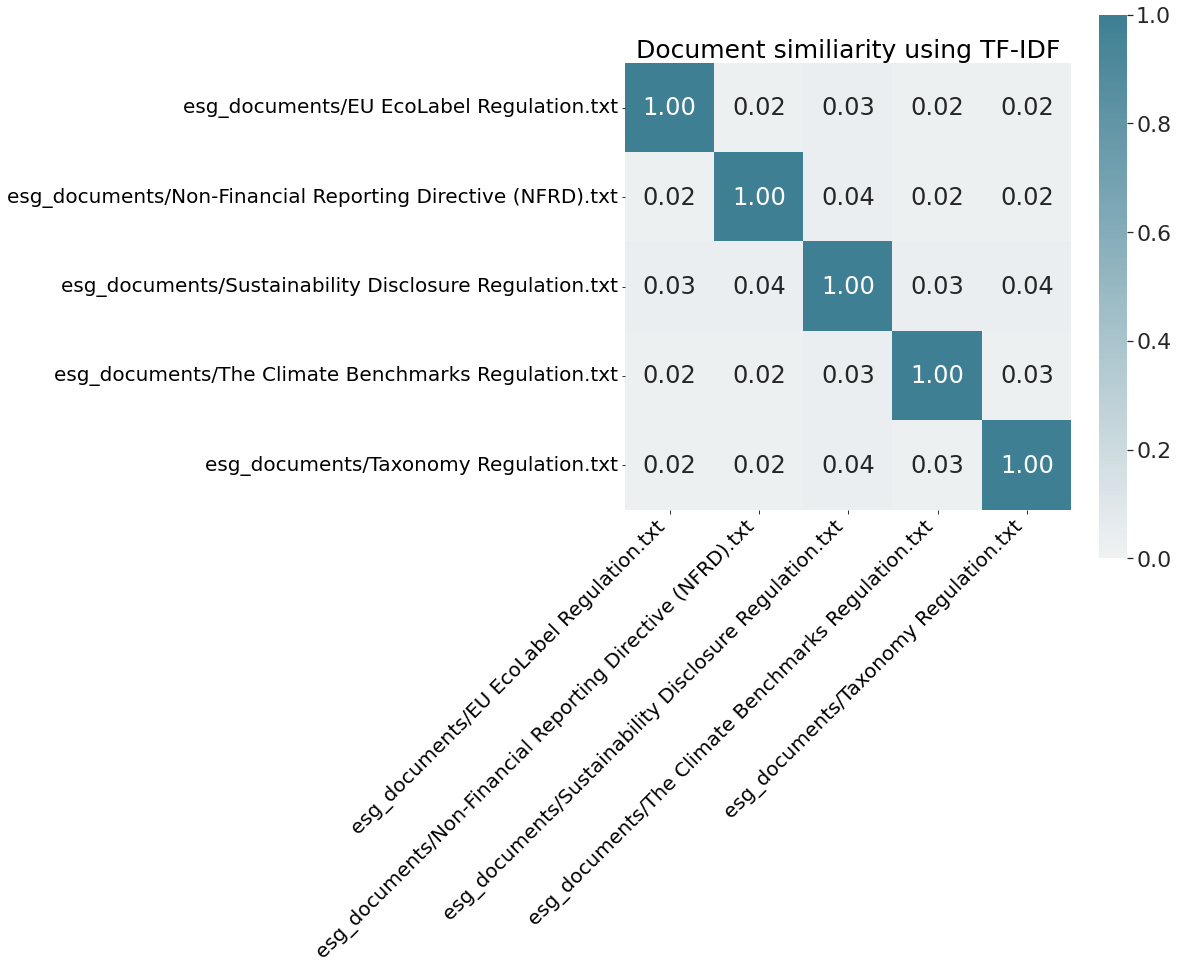

In [9]:
# Plotting heatmap to indicate the
# similarity between the documents
plt.figure(figsize=(10,10))
plt.title("Document similiarity using TF-IDF", fontsize=25)
sns.set(font_scale=2)
ax = sns.heatmap(
    sim_matrix, 
    vmin=0, vmax=1, center=0,
    cmap=sns.diverging_palette(100, 220, n=400),
    square=True,
    annot=True, fmt='.2f',
    xticklabels=file_list, 
    yticklabels=file_list
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize=20

);
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=20
);

## Result

1. The Result.csv file has unique pairs along with the similarity values.

2. The above heatmap provides the similarity between the respective documents. These documents similarity are calculated by taking average of all the span similarities.

## Observation

1. For vectorization tried different methods like Bag of words, Tf-IDF (term frequency and inverse document frequency), spacy large embedding model and sentence transformers (BERT) from huggingface.

2. Comparatively TF-IDF performed better.

3. Sentence embedding didn't perform well because it was not trained on the domain articles.

4. Bag-of-Words take the frequency of the words in consideration which does not perform well as it does not aaccount for important words or less frequent words.